# Pydough LLM Demo

This notebook showcases how an LLM can generate PyDough queries from natural language instructions. The goal is to demonstrate how AI can automate complex data analysis, making querying faster, more intuitive, and accessible without needing deep technical expertise.

Each example highlights different capabilities, including aggregations, filtering, ranking, and calculations across multiple collections.

---
## Setup & Basic Usage of the API

First, we import the created client.

In [1]:
from llm_v2 import LLMClient

Then we initialize the client.

In [2]:
client = LLMClient()

One should use the `ask()` method to make a query to the model.

We get a `result` object with the next attributes: 

- `code`:  The PyDough query generated by the LLM.
- `full_explanation`: A detailed explanation of how the query works.
- `df`:The dataframe containing the query results.
- `exception`: Stores any errors encountered while executing the query.
- `original_question`: The natural language question input by the user.
- `sql`: The SQL equivalent of the generated PyDough query.
- `base_prompt`: The initial instruction given to the LLM to generate the query.
- `cheat_sheet`:  A reference guide or example queries to help the LLM structure responses.
- `knowledge_graph`: The metadata structure that informs the LLM about available collections and relationships.
 


---
## First query

Ask method asks a simple query (no discourse mode)

In [3]:
import time

s_time = time.time()

result= client.ask("Give me all the suppliers name from united states")

e_time = time.time()

t_time = e_time - s_time

print (t_time)


suppliers_from_united_states = suppliers.WHERE(nation.name == "UNITED STATES").CALCULATE(supplier_name=name)
4.525022745132446


After that, we can consult all the necessary atributes from the result.

Initially, I want to check the **base instruction** that guided the LLM.

In [4]:
print(result.full_explanation)

```python
suppliers_from_united_states = suppliers.WHERE(nation.name == "UNITED STATES").CALCULATE(supplier_name=name)
```

**Explanation:**

1.  **`suppliers.WHERE(nation.name == "UNITED STATES")`**: This filters the `suppliers` collection to include only those suppliers whose `nation.name` is equal to "UNITED STATES".
2.  **`.CALCULATE(supplier_name=name)`**: This selects only the `name` field from the filtered suppliers and renames it to `supplier_name`.
3.  **`suppliers_from_united_states`**: This assigns the resulting collection to a variable named `suppliers_from_united_states`.



We can also ask for the for the **pydough code** directly.

In [5]:
print(result.code)

suppliers_from_united_states = suppliers.WHERE(nation.name == "UNITED STATES").CALCULATE(supplier_name=name)


And if we want to compare, we can get the **equivalent SQL query** created by Pydough.

In [6]:
print(result.sql)

SELECT
  name AS supplier_name
FROM (
  SELECT
    _table_alias_0.name AS name,
    _table_alias_1.name AS name_3
  FROM (
    SELECT
      s_name AS name,
      s_nationkey AS nation_key
    FROM main.SUPPLIER
  ) AS _table_alias_0
  LEFT JOIN (
    SELECT
      n_nationkey AS key,
      n_name AS name
    FROM main.NATION
  ) AS _table_alias_1
    ON nation_key = key
)
WHERE
  name_3 = 'UNITED STATES'


If we want to visually check, analyze or edit the resulting **dataframe**, we also can. There is a dedicated section for this later. on the document

In [7]:
result.df

,supplier_name
0,Supplier#000000010
1,Supplier#000000019
2,Supplier#000000046
3,Supplier#000000049
4,Supplier#000000055
...,...
388,Supplier#000009819
389,Supplier#000009829
390,Supplier#000009859
391,Supplier#000009906


We can also get a simple **explanation** of the query.

In the future, we will offer an English-only explanation to learn more about what the query is about, but for now, you can view a combined PyDough and English explanation generated by the LLM.


In [8]:
print(result.full_explanation)

```python
suppliers_from_united_states = suppliers.WHERE(nation.name == "UNITED STATES").CALCULATE(supplier_name=name)
```

**Explanation:**

1.  **`suppliers.WHERE(nation.name == "UNITED STATES")`**: This filters the `suppliers` collection to include only those suppliers whose `nation.name` is equal to "UNITED STATES".
2.  **`.CALCULATE(supplier_name=name)`**: This selects only the `name` field from the filtered suppliers and renames it to `supplier_name`.
3.  **`suppliers_from_united_states`**: This assigns the resulting collection to a variable named `suppliers_from_united_states`.



We can also check the original natural language **question** that was asked.

In [9]:
print(result.original_question)

Give me all the suppliers name from united states


We also have a reference guide or **cheat_sheet** with example queries to help structure responses.

In [10]:
print(result.cheat_sheet)

## **PYDOUGH CHEAT SHEET**  
This cheat sheet is a context for learning how to create PyDough code. You must follow all the written rules. Each section represents important features and rules to keep in mind when developing PyDough code. 

### **GENERAL RULES**: 

  - This is NOT SQL, so don't make assumptions about its syntax or behavior.

  - CALCULATE ONLY supports singular expressions. If you need to use plural sub-collections, you MUST use aggregation functions. Plural sub-collections refer to collections that have a one-to-many or many-to-many relationship.
  
  - RANKING is used as a function instead of method.
  
  - Always use TOP_K instead of ORDER_BY when you need to order but also select a the high, low or an specific "k" number of records.

  - When using functions like TOP_K, ORDER_BY, you must ALWAYS provide an expression, not a collection. Ensure that the correct type of argument is passed. For example, `supp_group.TOP_K(3, total_sales.DESC(na_pos='last')).CALCULATE(sup

Now, we will try a new example, this one has an **exception**.

---

## Query correction (early preview)

In [11]:
result= client.ask("For each of the 5 largest part sizes, find the part of that size with the largest retail price")

print(result.full_explanation)

top_parts = parts.CALCULATE(
    p_size=size,
    p_retail_price=retail_price
).PARTITION(
    parts.CALCULATE(p_size=size, p_retail_price=retail_price),
    name='size_group',
    by=p_size
).CALCULATE(
    p_size=p_size,
    top_part=size_group.ORDER_BY(p_retail_price.DESC()).TOP_K(1, by=p_retail_price.DESC())
).TOP_K(5, by=p_size.DESC())
```python
top_parts = parts.CALCULATE(
    p_size=size,
    p_retail_price=retail_price
).PARTITION(
    parts.CALCULATE(p_size=size, p_retail_price=retail_price),
    name='size_group',
    by=p_size
).CALCULATE(
    p_size=p_size,
    top_part=size_group.ORDER_BY(p_retail_price.DESC()).TOP_K(1, by=p_retail_price.DESC())
).TOP_K(5, by=p_size.DESC())
```

**Explanation:**

1. **`parts.CALCULATE(p_size=size, p_retail_price=retail_price)`**: This line selects the `size` and `retail_price` fields from the `parts` collection and renames them to `p_size` and `p_retail_price` respectively. This is done to avoid naming conflicts later on.
2. **`.PARTITION(

If one calls the dataframe and gets an error, no response, or a empty dataframe, it is possible that there is a PyDough exception. We can check this by running:

In [12]:
print(result.exception)

An error occurred while processing the code: Unrecognized term of simple table collection 'parts' in graph 'TPCH': 'parts'


You can try to fix the error using the `correct` method. We are going to declare a new variable to obtain the corrected result. 

In [13]:
corrected_result = client.correct(result)

top_parts = parts.CALCULATE(
    p_size=size,
    p_retail_price=retail_price
).TOP_K(5, by=size.DESC()).CALCULATE(
    p_size=p_size,
    top_part=parts.WHERE(size == p_size).TOP_K(1, by=retail_price.DESC()).name
)


To see how the model try to solve the issue, you can print the full explanation of the `corrected_result`.

In [14]:
print(corrected_result.code)

top_parts = parts.CALCULATE(
    p_size=size,
    p_retail_price=retail_price
).TOP_K(5, by=size.DESC()).CALCULATE(
    p_size=p_size,
    top_part=parts.WHERE(size == p_size).TOP_K(1, by=retail_price.DESC()).name
)


---
## Post-processing dataframe

Once the DataFrame is generated, it can be analysed or manipulated just like any other dataframe, using **any** Python package for analysis, visualization, or transformation. 

This is a planned future feature, and one of the core differentiators of PyDough!

As a first example, in this section we manipulate a resulting dataframe with pandas and matplotlib to create a histogram and a boxplot of the different orders prices.

In [15]:
result= client.ask("Give me all the order prices, name the column total_price")

result.df

order_prices = orders.CALCULATE(total_price=total_price)


,total_price
0,173665.47
1,46929.18
2,193846.25
3,32151.78
4,144659.20
...,...
1499995,114856.68
1499996,68906.56
1499997,92750.90
1499998,63216.65


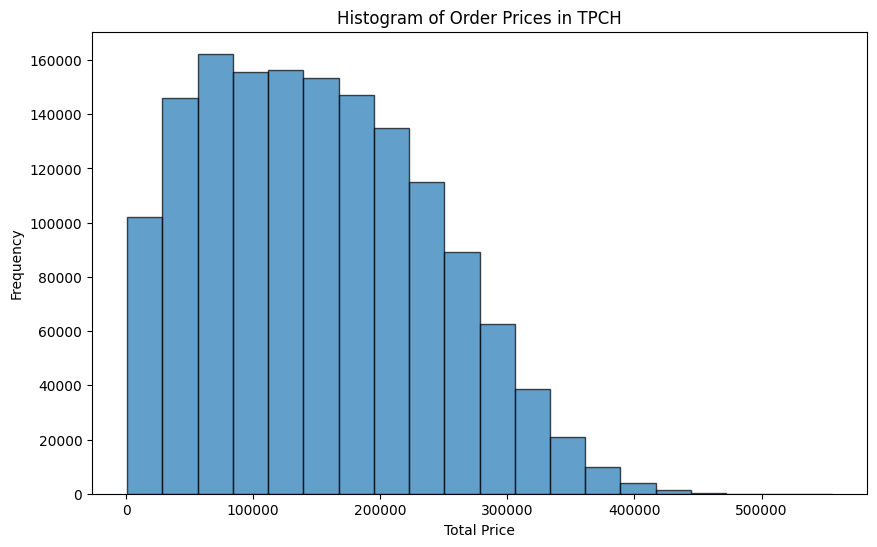

In [16]:
import matplotlib.pyplot as plt

df= result.df

plt.figure(figsize=(10, 6))
plt.hist(df["total_price"], bins=20, edgecolor="black", alpha=0.7)

# Configurar etiquetas y título
plt.xlabel("Total Price")
plt.ylabel("Frequency")
plt.title("Histogram of Order Prices in TPCH")

# Mostrar el gráfico
plt.show()

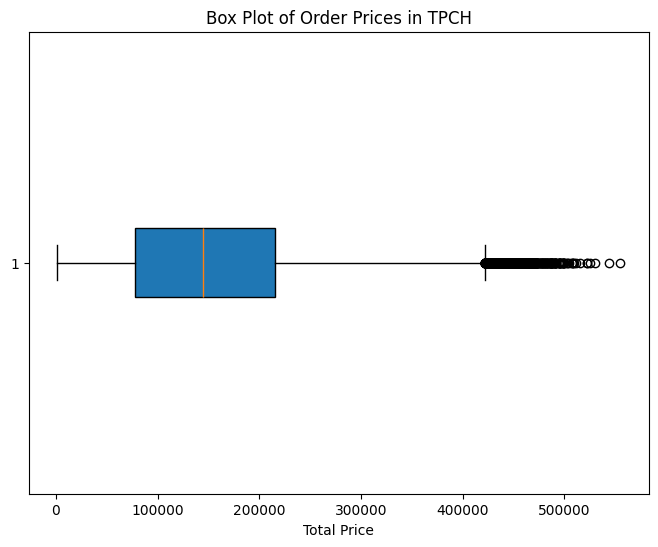

In [17]:
# Create a box plot for order prices
plt.figure(figsize=(8, 6))
plt.boxplot(df["total_price"], vert=False, patch_artist=True)

# Configure labels and title
plt.xlabel("Total Price")
plt.title("Box Plot of Order Prices in TPCH")

# Show the plot
plt.show()

---
## Query Quality and Verification

In the future we will be able to take the PyDough code, the user question, the knowledge graph and the generated data frame to perform semantic tests that will help assure the quality of the results. Some ideas that are under evaluation: 

1. John's graph reconstruction / deconstruction / verification ideas
2. LLM based rules that allow us to confirm certain properties of the Data Frame
   a. If the user requires a top 5 result, then the resulting DF must have 5 rows.
3. Program slicing ideas:
   b. If each cell can be traced to a transformation, look at the transformation and match it against the query (this is connected to John's ideas)
4. Emsemble ideas many variations prompts and LLMs could help us compare multiple results.
5. Talk about why Greg is flabbergasted. 

Here we show a simple demonstration of taking the resulting PyDough code, and then generating structured data from it so that you can compare the variables it used, against the original variables in our Knowledge Graph.

In [19]:
import ast
import json
from itertools import combinations
import networkx as nx
import matplotlib.pyplot as plt

class DSLGraphBuilder:
    class VariableNameExtractor(ast.NodeVisitor):
        def __init__(self):
            self.names = set()
        def visit_Name(self, node):
            # Ignore uppercase identifiers (like COUNT or YEAR)
            if not node.id.isupper():
                self.names.add(node.id)
            self.generic_visit(node)
    
    @staticmethod
    def extract_calculate_rhs_names(code):
        """
        Parse a DSL snippet and extract variable names from the right-hand side 
        of CALCULATE keyword assignments.
        """
        tree = ast.parse(code)
        names = set()
        for node in ast.walk(tree):
            if (
                isinstance(node, ast.Call)
                and isinstance(node.func, ast.Attribute)
                and node.func.attr == "CALCULATE"
            ):
                for kw in node.keywords:
                    extractor = DSLGraphBuilder.VariableNameExtractor()
                    extractor.visit(kw.value)
                    names.update(extractor.names)
        return names
    
    @classmethod
    def build_graph_from_snippets(cls, snippets):
        """
        Build a co-occurrence graph where each variable (from CALCULATE calls) 
        is a node, and an edge connects any two variables that appear together in a snippet.
        """
        all_nodes = set()
        snippet_vars = []  # list of sets of variable names per snippet
        for code in snippets:
            vars_in_snippet = cls.extract_calculate_rhs_names(code)
            snippet_vars.append(vars_in_snippet)
            all_nodes.update(vars_in_snippet)
        
        nodes = [{"id": var, "label": var} for var in sorted(all_nodes)]
        edges = []
        added_edges = set()
        for vars_in_snippet in snippet_vars:
            for a, b in combinations(sorted(vars_in_snippet), 2):
                key = tuple(sorted((a, b)))
                if key not in added_edges:
                    added_edges.add(key)
                    edges.append({"source": key[0], "target": key[1]})
        return {"nodes": nodes, "edges": edges}
    
    @staticmethod
    def visualize_graph(graph):
        """
        Visualize the graph using NetworkX and Matplotlib.
        """
        G = nx.Graph()
        for node in graph["nodes"]:
            G.add_node(node["id"])
        for edge in graph["edges"]:
            G.add_edge(edge["source"], edge["target"])
        
        # Use spring layout for a visually appealing graph
        pos = nx.spring_layout(G)
        
        plt.figure(figsize=(8, 6))
        nx.draw_networkx_nodes(G, pos, node_size=500, node_color="lightblue", edgecolors="black")
        nx.draw_networkx_edges(G, pos)
        nx.draw_networkx_labels(G, pos, font_size=10)
        
        plt.title("Co-occurrence Graph of Variables", fontsize=14)
        plt.axis("off")
        plt.tight_layout()
        plt.show()

ModuleNotFoundError: No module named 'networkx'

Now, this can be used to analyse the PyDough code that was first generated.

In [20]:
# Using the DSLGraphBuilder defined in a previous cell
builder = DSLGraphBuilder()

# Define your DSL code snippets to analyse

snippet1 = '''# Find all suppliers from the United States
us_suppliers = suppliers.WHERE(nation.name == "UNITED STATES").CALCULATE(
    supplier_name=name
)
'''
snippet2 = '''# Identify orders in 1995
orders_1995 = orders.WHERE(YEAR(order_date) == 1995)
european_customers = customers.CALCULATE(
    customer_name=name,
    account_balance=acctbal,
    num_orders_1995=COUNT(orders.WHERE(YEAR(order_date) == 1995))
).WHERE(
    (nation.region.name == "EUROPE") &
    (acctbal > 700) &
    (num_orders_1995 > 0)
)
'''

snippets = [snippet1, snippet2]

# Build the graph structure from your snippets
graph = builder.build_graph_from_snippets(snippets)

# Print out the graph JSON structure if desired
import json
print(json.dumps(graph, indent=4))

# Visualize the graph using matplotlib and networkx
builder.visualize_graph(graph)


NameError: name 'DSLGraphBuilder' is not defined

---
That generates a graphical view of the variables, and the co-occurence, and a json with that information, which can be compared against the original json knowledge graph for verification.

NB: This is only a first exploratory step, but as we have better ideas on verification, we will be able to add and extend this segment. Which is why it's an entire workstream as planned in our roadmap.

Now, on to more test cases!

---

## Test Cases

Let's now look at a few more test cases and see how PyDough and PyDough LLM does.

### Customer Segmentation

### 1. Find the names of all customers and the number of orders placed in 1995 in Europe.

- Demonstrates simple filtering, counting, and sorting while being business-relevant for regional market analysis. 
- Adds a second filtering layer by including account balance and order activity, making it more dynamic.

In [21]:

query= "Find the names of all customers and the number of orders placed in 1995 in Europe."

s_time = time.time()

result= client.ask(query)

e_time = time.time()

t_time = e_time - s_time

print(t_time)

print(result.full_explanation)
result.df.head()

customer_order_counts = customers.CALCULATE(
    cust_name=name,
    num_orders=COUNT(orders.WHERE(YEAR(order_date) == 1995))
).WHERE(nation.region.name == "EUROPE")
4.793072938919067
```python
customer_order_counts = customers.CALCULATE(
    cust_name=name,
    num_orders=COUNT(orders.WHERE(YEAR(order_date) == 1995))
).WHERE(nation.region.name == "EUROPE")
```

**Explanation:**

1.  **`customers.CALCULATE(...)`**: This starts with the `customers` collection and uses `CALCULATE` to create new fields or select existing ones.
2.  **`cust_name=name`**: Selects the `name` field from the `customers` collection and assigns it to a new field called `cust_name`.
3.  **`num_orders=COUNT(orders.WHERE(YEAR(order_date) == 1995))`**: This calculates the number of orders placed by each customer in 1995.
    *   `orders.WHERE(YEAR(order_date) == 1995)`: Filters the `orders` sub-collection to include only orders placed in the year 1995.
    *   `COUNT(...)`: Counts the number of orders that satisfy th

,cust_name,num_orders
0,Customer#000000011,1
1,Customer#000000015,0
2,Customer#000000018,0
3,Customer#000000020,3
4,Customer#000000026,2


**Follow up**: Now, give me the ones who have an account balance greater than $700 and placed at least one order in that same year. Sorted in descending order by the number of orders.

In [22]:
result= client.discourse(result, 
"""Now, give me the ones who have an account balance greater than $700 and placed at least one order in that same year. 
Sorted in descending order by the number of orders.""")

print(result.full_explanation)
result.df.head()

customer_order_counts = customers.CALCULATE(
    cust_name=name,
    num_orders=COUNT(orders.WHERE(YEAR(order_date) == 1995))
).WHERE((nation.region.name == "EUROPE") & (acctbal > 700) & (HAS(orders.WHERE(YEAR(order_date) == 1995))==1)).ORDER_BY(num_orders.DESC())
```python
customer_order_counts = customers.CALCULATE(
    cust_name=name,
    num_orders=COUNT(orders.WHERE(YEAR(order_date) == 1995))
).WHERE((nation.region.name == "EUROPE") & (acctbal > 700) & (HAS(orders.WHERE(YEAR(order_date) == 1995))==1)).ORDER_BY(num_orders.DESC())
```

**Explanation:**

1. **`customers.CALCULATE(...)`**: This initiates a calculation on the `customers` collection.
2. **`cust_name=name`**: Selects the `name` field from the `customers` collection and assigns it to a new field called `cust_name`.
3. **`num_orders=COUNT(orders.WHERE(YEAR(order_date) == 1995))`**: Calculates the number of orders placed in 1995 for each customer. It filters the `orders` sub-collection to include only those orders where the

,cust_name,num_orders
0,Customer#000107440,12
1,Customer#000014920,11
2,Customer#000079606,11
3,Customer#000108496,11
4,Customer#000009019,10


### 2. List customers who ordered in 1996 but not in 1997, with a total spent of over 1000$?

- Showcases PyDough’s HAS() and HASNOT() functions, helping analyze customer retention and spending patterns. 
- Also incorporates a time-based calculation.

In [26]:
import time
query= "List customers who ordered in 1996 but not in 1997 with a total spent of over 1000$. If you use HAS add a ==1. Return the customer name and the total spent in 1996"
s_time = time.time()

result= client.ask(query)

e_time = time.time()

t_time = e_time - s_time

print(t_time)

print(result.full_explanation)
result.df.head()

customers_1996_not_1997 = customers.CALCULATE(
    cust_name=name,
    total_spent_1996=SUM(orders.WHERE(YEAR(order_date) == 1996).total_price)
).WHERE(
    (total_spent_1996 > 1000) &
    (HAS(orders.WHERE(YEAR(order_date) == 1996)) == 1) &
    (HASNOT(orders.WHERE(YEAR(order_date) == 1997)) == 1)
).CALCULATE(cust_name=cust_name, total_spent_1996=total_spent_1996)
5.484804153442383
```python
customers_1996_not_1997 = customers.CALCULATE(
    cust_name=name,
    total_spent_1996=SUM(orders.WHERE(YEAR(order_date) == 1996).total_price)
).WHERE(
    (total_spent_1996 > 1000) &
    (HAS(orders.WHERE(YEAR(order_date) == 1996)) == 1) &
    (HASNOT(orders.WHERE(YEAR(order_date) == 1997)) == 1)
).CALCULATE(cust_name=cust_name, total_spent_1996=total_spent_1996)
```

**Explanation:**

1.  **`customers.CALCULATE(...)`**: This initiates a calculation on the `customers` collection.
2.  **`cust_name=name`**: Selects the customer's name and assigns it to the `cust_name` field.
3.  **`total_spent_199

,cust_name,total_spent_1996
0,Customer#000000005,98790.79
1,Customer#000000017,481076.02
2,Customer#000000020,538764.56
3,Customer#000000031,720459.29
4,Customer#000000038,788657.01


**Follow up**: Include the number of months since the last order and sort by total spent, highest first.

In [27]:
result2= client.discourse(result,
"Now, include the number of months since the last order and sort by total spent, highest first.")

print(result2.full_explanation)
result2.df.head() 

customers_1996_not_1997 = customers.CALCULATE(
    cust_name=name,
    total_spent_1996=SUM(orders.WHERE(YEAR(order_date) == 1996).total_price),
    last_order_date=MAX(orders.order_date)
).WHERE(
    (total_spent_1996 > 1000) &
    (HAS(orders.WHERE(YEAR(order_date) == 1996)) == 1) &
    (HASNOT(orders.WHERE(YEAR(order_date) == 1997)) == 1)
).CALCULATE(
    cust_name=cust_name,
    total_spent_1996=total_spent_1996,
    months_since_last_order=DATEDIFF("months", last_order_date, DATETIME('now'))
).ORDER_BY(total_spent_1996.DESC())
```python
customers_1996_not_1997 = customers.CALCULATE(
    cust_name=name,
    total_spent_1996=SUM(orders.WHERE(YEAR(order_date) == 1996).total_price),
    last_order_date=MAX(orders.order_date)
).WHERE(
    (total_spent_1996 > 1000) &
    (HAS(orders.WHERE(YEAR(order_date) == 1996)) == 1) &
    (HASNOT(orders.WHERE(YEAR(order_date) == 1997)) == 1)
).CALCULATE(
    cust_name=cust_name,
    total_spent_1996=total_spent_1996,
    months_since_last_order=DAT

,cust_name,total_spent_1996,months_since_last_order
0,Customer#000001948,1785971.27,321
1,Customer#000057892,1668071.25,320
2,Customer#000111028,1626293.12,319
3,Customer#000112711,1623258.35,322
4,Customer#000113131,1597282.31,320


### Sales Performance

### 3. Find the region name with the highest total order value in 1996.

- The total order value is defined as potential revenue, defined as the sum of extended_price * (1 - discount)
- It introduces precise calculations within the query, ensuring revenue insights.

In [28]:
query="""Find the region name with the highest total order value in 1996. 
The total order value is defined as potential revenue, defined as the sum of extended_price * (1 - discount)"""

result= client.ask(query)

print(result.full_explanation)
result.df.head()

region_revenue = regions.CALCULATE(
    region_name=name,
    total_revenue=SUM(nations.customers.orders.WHERE(YEAR(order_date) == 1996).lines.CALCULATE(revenue=extended_price * (1 - discount)).revenue)
).TOP_K(1, by=total_revenue.DESC())
```python
region_revenue = regions.CALCULATE(
    region_name=name,
    total_revenue=SUM(nations.customers.orders.WHERE(YEAR(order_date) == 1996).lines.CALCULATE(revenue=extended_price * (1 - discount)).revenue)
).TOP_K(1, by=total_revenue.DESC())
```

**Explanation:**

1.  **`regions.CALCULATE(...)`**: This initiates a calculation on the `regions` collection.
2.  **`region_name=name`**: This selects the name of the region and assigns it to the `region_name` field.
3.  **`total_revenue=SUM(...)`**: This calculates the total revenue for each region by summing the potential revenue from all orders placed in 1996 by customers in that region.
    *   **`nations.customers.orders.WHERE(YEAR(order_date) == 1996)`**: This navigates from regions to nations, t

,region_name,total_revenue
0,EUROPE,6.746079e+09


### Product Trends

### 4. Which 10 customers purchased the highest quantity of products during 1998?

Highlights ranking queries (TOP_K()), customer segmentation, and purchasing trends. 

In [33]:
query= "Which 10 customers purchased the highest quantity of products during 1998?"

result= client.ask(query)

print(result.full_explanation)
result.df.head()

customer_quantity = customers.CALCULATE(
    cust_key=key,
    cust_name=name,
    total_quantity=SUM(orders.WHERE(YEAR(order_date) == 1998).lines.quantity)
).TOP_K(10, by=total_quantity.DESC())
```python
customer_quantity = customers.CALCULATE(
    cust_key=key,
    cust_name=name,
    total_quantity=SUM(orders.WHERE(YEAR(order_date) == 1998).lines.quantity)
).TOP_K(10, by=total_quantity.DESC())
```

**Explanation:**

1.  **`customers.CALCULATE(...)`**: This initiates a calculation on the `customers` collection.
2.  **`cust_key=key`**: Selects the customer's key and assigns it to `cust_key`.
3.  **`cust_name=name`**: Selects the customer's name and assigns it to `cust_name`.
4.  **`total_quantity=SUM(orders.WHERE(YEAR(order_date) == 1998).lines.quantity)`**: This calculates the total quantity of products purchased by each customer in 1998.
    *   `orders.WHERE(YEAR(order_date) == 1998)`: Filters the orders to include only those placed in 1998.
    *   `.lines.quantity`: Accesses the 

,cust_key,cust_name,total_quantity
0,119539,Customer#000119539,1206
1,26518,Customer#000026518,1158
2,24877,Customer#000024877,1104
3,19,Customer#000000019,1084
4,106000,Customer#000106000,1058


**Follow up**: Now only the ones that have "green" on the product name.

In [34]:
result= client.discourse(result, "Only the ones that have 'green' on the product name.")

print(result.full_explanation)
result.df.head()

customer_quantity = customers.CALCULATE(
    cust_key=key,
    cust_name=name,
    total_quantity=SUM(orders.WHERE(YEAR(order_date) == 1998).lines.WHERE(part.name.CONTAINS('green')).quantity)
).TOP_K(10, by=total_quantity.DESC())
```python
customer_quantity = customers.CALCULATE(
    cust_key=key,
    cust_name=name,
    total_quantity=SUM(orders.WHERE(YEAR(order_date) == 1998).lines.WHERE(part.name.CONTAINS('green')).quantity)
).TOP_K(10, by=total_quantity.DESC())
```

**Explanation:**

1.  **`customers.CALCULATE(...)`**: This initiates a calculation on the `customers` collection.
2.  **`cust_key=key, cust_name=name`**: These lines select and rename the `key` and `name` fields from the `customers` collection to `cust_key` and `cust_name` respectively.
3.  **`total_quantity=SUM(orders.WHERE(YEAR(order_date) == 1998).lines.WHERE(part.name.CONTAINS('green')).quantity)`**: This calculates the total quantity of products purchased by each customer in 1998, but only for products that have 'g

AttributeError: 'NoneType' object has no attribute 'head'

### Revenue Performance (WIP)

### 5. What is the february 1996 SPM for the almond antique blue royal burnished part in China?

- SPM (Selling Profit Margin) = (Total Amount from Sells - (Tax + Commission)) / Total Amount from Sells * 100
- This query was provided as a representative example of potential stakeholder inquiries.
- Showcases advanced partitioning and filtering, demonstrating how PyDough can be used for highly specific business KPIs. 
- Compare with a previous time period and exclude/include specific suppliers, making it a progressive data exploration example.

In [35]:
query= """What is the february 1996 SPM for the almond antique blue royal burnished part in China? 
SPM (Selling Profit Margin) = (Total Amount from Sells - (Tax + Commission)) / Total Amount from Sells * 100"""

result= client.ask(query)

print(result.full_explanation)
print(result.df)

china_sales = parts.WHERE(
    (name == "almond") & (brand == "antique") & (container == "blue royal burnished")
).lines.WHERE(
    (YEAR(ship_date) == 1996) & (MONTH(ship_date) == 2) & (order.customer.nation.name == "CHINA")
).CALCULATE(
    total_amount=extended_price,
    tax_amount=tax,
    commission_amount=0  # Assuming commission is 0, clarify if needed
)

spm = china_sales.CALCULATE(
    spm=((total_amount - (tax_amount + commission_amount)) / total_amount) * 100
)
```python
china_sales = parts.WHERE(
    (name == "almond") & (brand == "antique") & (container == "blue royal burnished")
).lines.WHERE(
    (YEAR(ship_date) == 1996) & (MONTH(ship_date) == 2) & (order.customer.nation.name == "CHINA")
).CALCULATE(
    total_amount=extended_price,
    tax_amount=tax,
    commission_amount=0  # Assuming commission is 0, clarify if needed
)

spm = china_sales.CALCULATE(
    spm=((total_amount - (tax_amount + commission_amount)) / total_amount) * 100
)
```

**Explanation:**

1.  **Filte

**Follow up**: Compare that to november 1995 SPM, have we seen an increase?

In [36]:
result= client.discourse(result, "Compare that to november 1995 SPM, have we seen an increase?")

print(result.full_explanation)

# Calculate the SPM for February 1996 for the specified part in China
china_sales_feb_1996 = parts.WHERE(
    (name == "almond") & (brand == "antique") & (container == "blue royal burnished")
).lines.WHERE(
    (YEAR(ship_date) == 1996) & (MONTH(ship_date) == 2) & (order.customer.nation.name == "CHINA")
).CALCULATE(
    total_amount=extended_price,
    tax_amount=tax,
    commission_amount=0  # Assuming commission is 0, clarify if needed
)

spm_feb_1996 = china_sales_feb_1996.CALCULATE(
    spm=((total_amount - (tax_amount + commission_amount)) / total_amount) * 100
).CALCULATE(spm_value=spm)

# Calculate the SPM for November 1995 for the specified part in China
china_sales_nov_1995 = parts.WHERE(
    (name == "almond") & (brand == "antique") & (container == "blue royal burnished")
).lines.WHERE(
    (YEAR(ship_date) == 1995) & (MONTH(ship_date) == 11) & (order.customer.nation.name == "CHINA")
).CALCULATE(
    total_amount=extended_price,
    tax_amount=tax,
    commission_amount=0  # 

**Follow up**: Now exclude supplier Supplier#000001305 and focus only on supplier Supplier#000008802

In [37]:
result= client.discourse(result, """Now exclude supplier Supplier#000001305 
                         and focus only on supplier Supplier#000008802v""")

print(result.full_explanation)

# Calculate the SPM for February 1996 for the specified part in China, excluding Supplier#000001305 and focusing on Supplier#000008802
china_sales_feb_1996 = parts.WHERE(
    (name == "almond") & (brand == "antique") & (container == "blue royal burnished")
).lines.WHERE(
    (YEAR(ship_date) == 1996) & (MONTH(ship_date) == 2) & (order.customer.nation.name == "CHINA") & (supplier.name == "Supplier#000008802")
).CALCULATE(
    total_amount=extended_price,
    tax_amount=tax,
    commission_amount=0  # Assuming commission is 0, clarify if needed
)

spm_feb_1996 = china_sales_feb_1996.CALCULATE(
    spm=((total_amount - (tax_amount + commission_amount)) / total_amount) * 100
).CALCULATE(spm_value=spm)

# Calculate the SPM for November 1995 for the specified part in China, excluding Supplier#000001305 and focusing on Supplier#000008802
china_sales_nov_1995 = parts.WHERE(
    (name == "almond") & (brand == "antique") & (container == "blue royal burnished")
).lines.WHERE(
    (YEAR(ship_date)